In [1]:
import os
import re
import time
import copy
import pickle
from dataclasses import dataclass


from pathlib import Path, Path as P
from pathlib import Path
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch, Ellipse
from matplotlib.ticker import MultipleLocator
from numpy.linalg import lstsq
from pathlib import Path


import matplotlib.image as mpimg


plt.rcParams.update({
    "axes.labelsize": 16,   # fontsize for axis labels
    "xtick.labelsize": 14,  # fontsize for x-axis tick labels
    "ytick.labelsize": 14   # fontsize for y-axis tick labels
})

## Set experimental parameters

Model parameters:

In [2]:
initial_resource = 1.0
simulation_time = 24.0
B0=1e6
od2cells = 1e9

ref_family=''
ref_key='pMBA'

Simulation parameters:

In [3]:
def make_switch_schedule(first_env="G", switch_day=10, num_days=30, second_env="E"):
    if switch_day < 0 or switch_day > num_days:
        raise ValueError("switch_day must be in [0, num_days]")
    return [first_env] * switch_day + [second_env] * (num_days - switch_day)


In [4]:
#labels_of_interest = ["ereA2", "aacA7", "OXA10", "dfrA31","qacE","OXA1","OXA118","fosF", "BEL1", "GES1", "IMP2", "IMP31", "OXA129","OXA196", "VIM2", "VIM7", "dfrA6", "dfrB2", "aphA16", "aadB", "fosC2", "fosE", "fosG", "fosH", "fosI", "fosK", "fosL", "fosM", "fosN"]

n_syn=1000

labels_of_interest = ["ereA2", "aacA7", "OXA10", "dfrA31","qacE"]
families=['all','dfr', 'bla', 'aa', 'mix']

exportData=True
simulateData=True


In [5]:

num_days = 14
K=7 # Day when switch to aerobiosis is performed
sched_name = 'Switch_K%s'%K

schedule = make_switch_schedule(first_env="G", switch_day=K, num_days=num_days, second_env="E")

E_color = "#B63E36"   # aerobiosis (anaerobiosis)
G_color = "#EBDD99"   # anaerobiosis (aerobiosis)

Ks_to_show = [25, 50, 75]

## Clone GitHub Repo

In [6]:

REPO=False


if REPO:
    repo_url = "https://github.com/ccg-esb-lab/ARCfitness.git"
    repo_name = "ARCfitness"
    
    if not Path(repo_name).exists():
        !git clone {repo_url}
    
    REPO_ROOT = Path(repo_name).resolve()
    print("Repo root:", REPO_ROOT)
    
    # Create local folders for figures and processed simulations.
    pathCODE = REPO_ROOT / "code"
    pathFIGURES = REPO_ROOT / "figures"
    pathSIM = REPO_ROOT / "sim"
    
    pathFIGURES.mkdir(parents=True, exist_ok=True)
    pathSIM.mkdir(parents=True, exist_ok=True)



In [7]:
if not REPO:
    REPO_ROOT = Path("./").expanduser().resolve()
    
    if not REPO_ROOT.exists():
        raise FileNotFoundError(f"Repo not found at {REPO_ROOT}")
    
    print("Repo root:", REPO_ROOT)
    
    pathCODE    = REPO_ROOT / "code"
    pathFIGURES = REPO_ROOT / "figures"
    pathDATA    = REPO_ROOT / "data"
    
    # Create output dirs if missing
    pathFIGURES.mkdir(parents=True, exist_ok=True)
    
    print("pathCODE:", pathCODE)
    print("pathDATA:", pathDATA)
    print("pathFIGURES:", pathFIGURES)


Repo root: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main
pathCODE: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/code
pathDATA: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/data
pathFIGURES: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/figures


___

In [8]:
def load_all_fits(csv_path, min_r2=0.9):
    """
    Load fitted parameters from a CSV file and build a lookup map.

    Parameters:
    - csv_path: path to the CSV created by save_fit_to_csv.
    - min_r2: minimum R2 threshold applied if the column exists.

    Returns:
    - fits_df: DataFrame of all fits (optionally filtered by R2).
    - param_map: dict keyed by (family, strain) with fitted parameters.
    """
    fits_df = pd.read_csv(csv_path).dropna(how="all").dropna(axis=1, how="all")
    if fits_df.empty:
        raise ValueError(f"No rows in '{csv_path}'.")

    fits_df["family"] = fits_df["family"].astype("string")
    fits_df["strain"] = fits_df["strain"].astype("string")

    if "R2" in fits_df.columns:
        fits_df = fits_df[fits_df["R2"] >= min_r2].reset_index(drop=True)

    param_map = {}
    for _, r in fits_df.iterrows():
        key = (str(r["family"]), str(r["strain"]))
        param_map[key] = {
            "Vmax": float(r["Vmax"]),
            "K": float(r["K"]),
            "c": float(r["c"]),
            "N0": float(r.get("N0_cells", 2e8)),
            "R2": float(r.get("R2", np.nan)),
        }

    return fits_df, param_map


def get_params(fits_df, family, strain):
    """
    Retrieve the first matching parameter set for a given strain and family.
    If family is an empty string or None, match only on strain.
    """
    if family:
        row = fits_df[(fits_df["family"] == family) & (fits_df["strain"] == strain)]
    else:
        row = fits_df[fits_df["strain"] == strain]

    if row.empty:
        raise ValueError(f"No parameters found for {strain} ({family if family else 'any family'})")

    return {
        "Vmax": float(row["Vmax"].iloc[0]),
        "K": float(row["K"].iloc[0]),
        "c": float(row["c"].iloc[0]),
    }


min_r2 = 0.9
csv_path = REPO_ROOT / "data" / "params_fits.csv"

fits_df, PARAMS = load_all_fits(csv_path, min_r2=min_r2)
print(f"Loaded {len(PARAMS)} fitted strains with R² >= {min_r2}.")

ref_key = ("", "pMBA")
p0 = get_params(fits_df, ref_key[0], ref_key[1])
print(f"p0={p0}")

p0_df = pd.DataFrame(
    {
        "V": [p0["Vmax"], p0["Vmax"]],
        "K": [p0["K"], p0["K"]],
        "c": [p0["c"], p0["c"]],
    },
    index=["E", "G"],
)


Loaded 115 fitted strains with R² >= 0.9.
p0={'Vmax': 0.9439199210132264, 'K': 1.999766742907286, 'c': 1.0682752135140286e-09}


In [9]:
def _norm(s):
    return re.sub(r"[^a-z0-9]+", "", str(s).lower())


def load_exp_fitness_csv(csv_path):
    """
    Load experimental fitness from a CSV export.

    Parameters:
    - csv_path: path to a CSV with columns ARC and either mean, or replicate columns named as digits.

    Returns:
    - DataFrame with columns strain, w_exp, _key.
    """
    df = pd.read_csv(csv_path).dropna(how="all").dropna(axis=1, how="all")

    rep_cols = [c for c in df.columns if str(c).strip().isdigit()]

    if "mean" in df.columns:
        df["w_exp"] = pd.to_numeric(df["mean"], errors="coerce")
    else:
        df["w_exp"] = pd.to_numeric(df[rep_cols], errors="coerce").mean(axis=1)

    df = df.rename(columns={"ARC": "strain"}).dropna(subset=["strain", "w_exp"])
    df["_key"] = df["strain"].map(_norm)

    return df[["strain", "w_exp", "_key"]]


fitness_aero = load_exp_fitness_csv(REPO_ROOT / "data" / "ARC_fitness_aerobiosis.csv")
print(fitness_aero.head())

fitness_anaero = load_exp_fitness_csv(REPO_ROOT / "data" / "ARC_fitness_anaerobiosis.csv")
print(fitness_anaero.head())


   strain     w_exp    _key
0    VIM1  0.691702    vim1
1    VIM2  0.713427    vim2
2    OXA2  0.731454    oxa2
3  OXA118  0.733002  oxa118
4   IMP31  0.733117   imp31
   strain     w_exp    _key
0   dfrA1  0.931405   dfra1
1   dfrA5  0.965603   dfra5
2   dfrA6  0.910117   dfra6
3   dfrA7  0.858955   dfra7
4  dfrA12  0.937613  dfra12


In [10]:
def load_exp_fitness(csv_path, strain_col="ARC"):
    """Collapse replicates and return numeric mean and SD."""
    df = pd.read_csv(csv_path).dropna(how="all").dropna(axis=1, how="all")

    rep_cols = [c for c in df.columns if str(c).strip().isdigit()]

    df["w_exp"] = (
        pd.to_numeric(df["mean"], errors="coerce")
        if "mean" in df.columns
        else pd.to_numeric(df[rep_cols], errors="coerce").mean(axis=1)
    )

    df["w_exp_std"] = (
        pd.to_numeric(df["desvest"], errors="coerce")
        if "desvest" in df.columns
        else pd.to_numeric(df[rep_cols], errors="coerce").std(axis=1, ddof=1)
    )

    df = df.rename(columns={strain_col: "strain"}) \
           .dropna(subset=["strain", "w_exp"])

    df["_key"] = df["strain"].map(_norm)

    return df[["strain", "w_exp", "w_exp_std", "_key"]]


fitness_aero   = load_exp_fitness(REPO_ROOT / "data" / "ARC_fitness_aerobiosis.csv")
fitness_anaero = load_exp_fitness(REPO_ROOT / "data" / "ARC_fitness_anaerobiosis.csv")


In [11]:

# --- normalizer reused everywhere ---
def _norm(s):
    return re.sub(r'[^a-z0-9]+', '', str(s).lower())

def attach_family_to_exp(exp_df, fits_df, verbose=True):
    """
    Add 'family' to an experimental fitness table using fits_df.
    Keeps all columns in exp_df (including '_key').

    exp_df must have: 'strain' (and optionally '_key')
    fits_df must have: 'strain', 'family'
    """
    exp = exp_df.copy()
    fits = fits_df.copy()

    if "strain" not in exp.columns:
        raise ValueError("attach_family_to_exp: exp_df missing column 'strain'")
    if "strain" not in fits.columns or "family" not in fits.columns:
        raise ValueError("attach_family_to_exp: fits_df must have columns 'strain' and 'family'")

    # Ensure _key exists for rescue matching
    if "_key" not in exp.columns:
        exp["_key"] = exp["strain"].map(_norm)

    fits = fits[["strain", "family"]].copy()
    fits["strain"] = fits["strain"].astype(str)
    fits["family"] = fits["family"].astype(str)
    fits["_key"] = fits["strain"].map(_norm)

    if verbose:
        print(f"[attach] exp rows: {len(exp)}, fits rows: {len(fits)}, fits unique strains: {fits['strain'].nunique()}")

    # 1) exact match on strain
    out = exp.merge(
        fits[["strain", "family"]],
        on="strain",
        how="left",
        suffixes=("", "_fit"),
    )

    # 2) rescue with _key when exact match failed
    need = out["family"].isna()
    if need.any():
        key2fam = fits.dropna(subset=["_key", "family"]).drop_duplicates("_key")[["_key", "family"]]
        out.loc[need, "family"] = out.loc[need].merge(key2fam, on="_key", how="left")["family_y"].values

    return out




# --- aggregate by family: simple mean/std across ARCs belonging to that family ---
def family_fitness_stats(exp_with_family_df, family):
    sub = exp_with_family_df[exp_with_family_df['family'] == family].dropna(subset=['w_exp'])
    if sub.empty:
        raise ValueError(f"No experimental fitness rows found for family '{family}'.")
    # simple across-ARC stats
    mean_w = float(sub['w_exp'].mean())
    std_w  = float(sub['w_exp'].std(ddof=1)) if len(sub) > 1 else float('nan')
    n      = int(len(sub))
    # optional: weighted mean using ARC-level std (if you prefer)
    if sub['w_exp_std'].notna().all() and (sub['w_exp_std'] > 0).any():
        w = 1.0 / (sub['w_exp_std']**2).replace([pd.NA, 0], pd.NA)
        if w.notna().any():
            w_mean = float((w * sub['w_exp']).sum() / w.sum())
        else:
            w_mean = mean_w
    else:
        w_mean = mean_w
    return {
        'family': family,
        'n_ARCs': n,
        'mean_w_exp': mean_w,
        'std_w_exp': std_w,
        'weighted_mean_w_exp': w_mean,
        'strains': (sub['strain'].unique().tolist())
    }

def get_family_w_exp(sheet, family, tab='fitness_aerobiosis', min_r2=0.9):
    exp = load_exp_fitness(sheet, tab=tab)
    fits_df, _ = load_all_fits(sheet, tab="params_fits", min_r2=min_r2)
    exp_wfam = attach_family_to_exp(exp, fits_df)
    return family_fitness_stats(exp_wfam, family)


def get_family_strains_and_stats(exp_wfam, family):
    sub = exp_wfam[exp_wfam['family'] == family].dropna(subset=['w_exp'])
    if sub.empty:
        raise ValueError(f"No experimental fitness data for family {family}")
    return {
        'family': family,
        'strains': sub['strain'].tolist(),
        'w_exp': sub['w_exp'].tolist(),
        'mean_w_exp': float(sub['w_exp'].mean()),
        'std_w_exp': float(sub['w_exp'].std(ddof=1)) if len(sub) > 1 else float('nan'),
        'n': len(sub)
    }

def get_family_exp_stats(family, fits_df, fitness_exp):
    """
    Given a family, the fits_df (with family/strain mapping),
    and the experimental fitness dataframe (with w_exp, w_exp_std),
    return ARC-level values and family-level summary.
    """
    # 1) Get all ARCs (strains) belonging to this family
    strains = fits_df.loc[fits_df['family'] == family, 'strain'].unique()

    rows = []
    for s in strains:
        val = fitness_exp.loc[fitness_exp['strain'] == s, ['w_exp', 'w_exp_std']]
        if not val.empty:
            mu_w, sigma_w = val.iloc[0,0], val.iloc[0,1]
            rows.append({'strain': s, 'w_exp': mu_w, 'w_exp_std': sigma_w})

    df_family = pd.DataFrame(rows)

    # 2) Family-level mean & std across ARCs
    mean_w = df_family['w_exp'].mean() if not df_family.empty else np.nan
    std_w  = df_family['w_exp'].std(ddof=1) if len(df_family) > 1 else np.nan

    return df_family, mean_w, std_w





In [12]:
def load_paired_family_exp(
    family,
    fitness_E_csv,
    fitness_G_csv,
    fits_csv,
    min_r2=0.9,
):
    """
    Build paired experimental fitness (E,G) for a family using CSV inputs.

    Parameters:
    - family: family label to keep, or "all" for pooled.
    - fitness_E_csv: path to fitness aerobiosis CSV.
    - fitness_G_csv: path to fitness anaerobiosis CSV.
    - fits_csv: path to fitted-parameters CSV used to attach family labels.
    - min_r2: minimum R2 threshold applied when loading fitted parameters.

    Returns:
    - DataFrame with columns: strain, w_E, w_E_std, w_G, w_G_std.
    """
    exp_E = load_exp_fitness(fitness_E_csv)   # strain, w_exp, w_exp_std, _key
    exp_G = load_exp_fitness(fitness_G_csv)   # same
    fits_df, _ = load_all_fits(fits_csv, min_r2=min_r2)

    exp_E_fam = attach_family_to_exp(exp_E, fits_df)
    exp_G_fam = attach_family_to_exp(exp_G, fits_df)

    if family != "all":
        exp_E_fam = exp_E_fam[exp_E_fam["family"] == family]
        exp_G_fam = exp_G_fam[exp_G_fam["family"] == family]

    paired = pd.merge(
        exp_E_fam[["strain", "w_exp", "w_exp_std"]].rename(
            columns={"w_exp": "w_E", "w_exp_std": "w_E_std"}
        ),
        exp_G_fam[["strain", "w_exp", "w_exp_std"]].rename(
            columns={"w_exp": "w_G", "w_exp_std": "w_G_std"}
        ),
        on="strain",
        how="inner",
    ).dropna(subset=["w_E", "w_G"])

    print(f"[load_paired_family_exp] family={family}, paired rows={len(paired)}")
    return paired


def estimate_family_bivariate_params(paired_df, shrink_r=0.05, ridge=1e-6):
    """
    Estimate mean vector and covariance for (w_E, w_G) using paired observations.
    """
    if paired_df.empty or paired_df["w_E"].count() < 3:
        return None

    wE = paired_df["w_E"].astype(float).values
    wG = paired_df["w_G"].astype(float).values

    mu_E = float(np.mean(wE))
    mu_G = float(np.mean(wG))
    sd_E = float(np.std(wE, ddof=1)) if len(wE) > 1 else 0.0
    sd_G = float(np.std(wG, ddof=1)) if len(wG) > 1 else 0.0

    if sd_E == 0.0 or sd_G == 0.0:
        rho_hat = 0.0
    else:
        rho_hat = float(np.corrcoef(wE, wG)[0, 1])

    rho = (1.0 - shrink_r) * rho_hat

    cov = np.array(
        [[sd_E**2, rho * sd_E * sd_G],
         [rho * sd_E * sd_G, sd_G**2]],
        dtype=float,
    )
    cov.flat[::3] += ridge

    return {
        "mu": np.array([mu_E, mu_G], dtype=float),
        "sd": (sd_E, sd_G),
        "rho": rho,
        "cov": cov,
    }


def sample_bivariate_w(n, mu, cov, clip_min=None, clip_max=None, seed=None):
    rng = np.random.default_rng(seed)
    samples = rng.multivariate_normal(mean=mu, cov=cov, size=n)

    if clip_min is not None or clip_max is not None:
        if clip_min is None:
            clip_min = -np.inf
        if clip_max is None:
            clip_max = np.inf
        samples = np.clip(samples, clip_min, clip_max)

    return samples


def build_synthetic_targets_for_family(
    family,
    fitness_E_csv,
    fitness_G_csv,
    fits_csv,
    n=1000,
    min_r2=0.9,
    clip_range=(0.05, 3.0),
    seed=None,
):
    """
    Generate target pairs (w_E_target, w_G_target) for a family using CSV inputs.
    Uses a bivariate Normal when paired data are sufficient, otherwise independent marginals.
    """
    paired = load_paired_family_exp(
        family=family,
        fitness_E_csv=fitness_E_csv,
        fitness_G_csv=fitness_G_csv,
        fits_csv=fits_csv,
        min_r2=min_r2,
    )

    stats = estimate_family_bivariate_params(paired)

    if stats is not None:
        samp = sample_bivariate_w(
            n, stats["mu"], stats["cov"],
            clip_min=clip_range[0], clip_max=clip_range[1],
            seed=seed,
        )
        out = pd.DataFrame(samp, columns=["w_E_target", "w_G_target"])
        out["family"] = family
        out["method"] = "bivariate"
        out["rho_used"] = stats["rho"]
        return out

    exp_E = load_exp_fitness(fitness_E_csv)
    exp_G = load_exp_fitness(fitness_G_csv)
    fits_df, _ = load_all_fits(fits_csv, min_r2=min_r2)

    exp_E_fam = attach_family_to_exp(exp_E, fits_df)
    exp_G_fam = attach_family_to_exp(exp_G, fits_df)

    if family != "all":
        subE = exp_E_fam[exp_E_fam["family"] == family]["w_exp"].dropna().values
        subG = exp_G_fam[exp_G_fam["family"] == family]["w_exp"].dropna().values
    else:
        subE = exp_E_fam["w_exp"].dropna().values
        subG = exp_G_fam["w_exp"].dropna().values

    muE = float(np.mean(subE))
    sdE = float(np.std(subE, ddof=1)) if len(subE) > 1 else 0.0
    muG = float(np.mean(subG))
    sdG = float(np.std(subG, ddof=1)) if len(subG) > 1 else 0.0

    rng = np.random.default_rng(seed)
    wE = rng.normal(muE, sdE, size=n)
    wG = rng.normal(muG, sdG, size=n)

    if clip_range is not None:
        wE = np.clip(wE, clip_range[0], clip_range[1])
        wG = np.clip(wG, clip_range[0], clip_range[1])

    out = pd.DataFrame({
        "w_E_target": wE,
        "w_G_target": wG,
        "family": family,
        "method": "marginals",
        "rho_used": 0.0,
    })
    return out


In [13]:

def _ellipse_axis_aligned(ax, x, y, nsig_levels=(1,2), color='black', alpha=0.8, lw=1.5):
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 2:  # need at least 2 points for std
        return
    mu_x, mu_y = np.nanmean(x), np.nanmean(y)
    sx = np.nanstd(x, ddof=1) if x.size >= 2 else 0.0
    sy = np.nanstd(y, ddof=1) if y.size >= 2 else 0.0
    if not (np.isfinite(sx) and np.isfinite(sy)) or (sx == 0 and sy == 0):
        return
    for nsig in nsig_levels:
        w = 2 * nsig * sx
        h = 2 * nsig * sy
        if w > 0 and h > 0:
            ax.add_patch(Ellipse((mu_x, mu_y), width=w, height=h, angle=0.0,
                                 edgecolor=color, facecolor='none', lw=lw, alpha=alpha, zorder=3))

def _ellipse_rotated(ax, x, y, nsig_levels=(1,2), color='black', alpha=0.8, lw=1.5):
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 3:  # covariance needs ≥3 for stable ddof=1
        return
    mu_x, mu_y = np.nanmean(x), np.nanmean(y)
    cov = np.cov(np.vstack([x, y]), ddof=1)
    if not np.all(np.isfinite(cov)):
        return
    vals, vecs = np.linalg.eigh(cov)          # ascending eigenvalues
    vals = np.clip(vals, 0.0, None)           # numeric safety
    angle_deg = np.degrees(np.arctan2(vecs[1,1], vecs[0,1]))  # major axis angle
    for nsig in nsig_levels:
        w = 2 * nsig * np.sqrt(vals[1])       # major axis
        h = 2 * nsig * np.sqrt(vals[0])       # minor axis
        if np.isfinite(w) and np.isfinite(h) and w > 0 and h > 0:
            ax.add_patch(Ellipse((mu_x, mu_y), width=w, height=h, angle=angle_deg,
                                 edgecolor=color, facecolor='none', lw=lw, alpha=alpha, zorder=3))


def plot_w_scatter(
    df_env,
    family=None,
    highlight=None,
    annotate=None,
    *,
    ellipse_mode='rotated',      # 'axis' | 'rotated' | 'auto'
    corr_threshold=0.2,          # only for ellipse_mode='auto'
    nsig_levels=(1,2),
    ellipse_color='#666666',
    ellipse_alpha=0.8,
    ellipse_lw=1.5,
    family_colors=None,          # dict like {'bla':'#1f77b4', ...}; used if family=None
    pathFIGURES='',
    ax=None
):
    """
    Scatter of relative fitness (w) in anaerobiosis (G, x-axis) vs aerobiosis (E, y-axis),
    per label, with covariance ellipses.

    df_env must have columns:
        ['label','Environment','achieved_w','family'].

    If `family` is not None:
        - Subset df_env to that family and plot it as a single cloud.
        - Draw a single ellipse on that cloud.

    If `family` is None:
        - Assume df_env may contain multiple families.
        - Plot each family in a different color.
        - Draw one ellipse per family (using that family's color).
        - Title is generic and we include a legend.

    highlight : list-like of labels to highlight (drawn on top, yellow)
    annotate  : list-like of labels to annotate with text

    Returns:
        A dict mapping family_name -> pivot_dataframe, where each pivot_dataframe
        has columns ['label','G','E','family'].
        In single-family mode, it's a dict with one key.
    """

    # defaults
    highlight = set(highlight or [])
    annotate  = set(annotate or [])

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
        created_fig = True

    def _pivot_one_family(df_sub, fam_name):
        """
        df_sub: rows of a SINGLE family
        returns pivot with columns ['label','G','E','family'] if possible
        """
        pivot = (
            df_sub.pivot_table(
                index="label",
                columns="Environment",
                values="achieved_w",
                aggfunc="mean"
            )
            .reset_index()
        )

        # Check that both environments we want are present
        missing_envs = [env for env in ['G', 'E'] if env not in pivot.columns]
        if missing_envs:
            # No paired G/E values for this family → nothing to plot
            return pd.DataFrame(columns=["label", "G", "E", "family"])

        # Drop rows that do not have BOTH E and G
        pivot = pivot.dropna(subset=['G', 'E'], how='any')

        if pivot.empty:
            return pd.DataFrame(columns=["label", "G", "E", "family"])

        pivot['family'] = fam_name
        return pivot[['label', 'G', 'E', 'family']]


    # branch 1: single family mode
    if family is not None:
        df_use = df_env[df_env['family'] == family].copy()
        if df_use.empty:
            raise ValueError(f"No rows found for family '{family}'.")

        pivot = _pivot_one_family(df_use, family)
        if pivot.empty:
            raise ValueError(f"Family '{family}' has no paired E/G fitness values.")

        # base scatter for this family
        x = pivot['G'].astype(float).to_numpy()
        y = pivot['E'].astype(float).to_numpy()
        ax.scatter(x, y, color='grey', alpha=0.2, s=20)

        # highlight subset (true experimental strains or strains of interest)
        if highlight:
            df_hl = pivot[pivot['label'].isin(highlight)]
            ax.scatter(df_hl['G'], df_hl['E'], color='yellow', alpha=0.7, s=20)

        # annotate subset
        if annotate:
            df_ann = pivot[pivot['label'].isin(annotate)]
            ax.scatter(df_ann['G'], df_ann['E'], color='red', alpha=0.8)
            for _, row in df_ann.iterrows():
                ax.text(
                    float(row['G']) + 0.01,
                    float(row['E']),
                    row['label'],
                    fontsize=9,
                    ha='left',
                    va='center',
                    color='red'
                )

        # choose ellipse mode
        _draw_ellipse_for_points(
            ax, x, y,
            ellipse_mode=ellipse_mode,
            corr_threshold=corr_threshold,
            nsig_levels=nsig_levels,
            ellipse_color=ellipse_color,
            ellipse_alpha=ellipse_alpha,
            ellipse_lw=ellipse_lw
        )

        # axis formatting
        ax.set_xlim(0.5, 1.5)
        ax.set_ylim(0.5, 1.5)
        ax.set_aspect('equal', adjustable='box')
        ax.axhline(1, color='black', linestyle='--', alpha=0.7)
        ax.axvline(1, color='black', linestyle='--', alpha=0.7)
        ax.set_xlabel("Relative fitness (anaerobiosis)")
        ax.set_ylabel("Relative fitness (aerobiosis)")
        ax.set_title(family.upper())

        # save/show if standalone
        if created_fig:
            plt.tight_layout()
            if pathFIGURES:
                filename = f"{pathFIGURES}/w_scatter_{family}.png"
                plt.savefig(filename, format='png', bbox_inches='tight')
                print(f"Exporting {filename}")
            plt.show()

        return {family: pivot}

    # branch 2: multi-family overlay mode
    # -----------------------------------
    fam_results = {}
    fam_list = sorted(df_env['family'].dropna().unique().tolist())
    if family_colors is None:
        # fallback palette
        default_cols = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']
        family_colors = {f: default_cols[i % len(default_cols)] for i, f in enumerate(fam_list)}

    for fam_name in fam_list:
        df_sub = df_env[df_env['family'] == fam_name].copy()
        if df_sub.empty:
            continue

        pivot_f = _pivot_one_family(df_sub, fam_name)
        if pivot_f.empty:
            continue

        fam_results[fam_name] = pivot_f

        x = pivot_f['G'].astype(float).to_numpy()
        y = pivot_f['E'].astype(float).to_numpy()
        col = family_colors.get(fam_name, 'gray')

        # scatter for this family
        ax.scatter(
            x, y,
            s=20,
            alpha=0.4,
            color=col
        )

        # annotate/highlight logic could optionally be family-specific;
        # here we apply globally:
        if highlight:
            df_hl = pivot_f[pivot_f['label'].isin(highlight)]
            if not df_hl.empty:
                ax.scatter(df_hl['G'], df_hl['E'], color='yellow', alpha=0.7, s=20)
        if annotate:
            df_ann = pivot_f[pivot_f['label'].isin(annotate)]
            if not df_ann.empty:
                ax.scatter(df_ann['G'], df_ann['E'], color='red', alpha=0.8)
                for _, row in df_ann.iterrows():
                    ax.text(
                        float(row['G']) + 0.01,
                        float(row['E']),
                        row['label'],
                        fontsize=9,
                        ha='left',
                        va='center',
                        color='red'
                    )

        # ellipse for this family, in that family's color but transparent
        _draw_ellipse_for_points(
            ax, x, y,
            ellipse_mode=ellipse_mode,
            corr_threshold=corr_threshold,
            nsig_levels=nsig_levels,
            ellipse_color=col,
            ellipse_alpha=0.15,        # lighter fill for multi-family
            ellipse_lw=1.5
        )

    # common axis formatting for overlay
    ax.set_xlim(0.5, 1.5)
    ax.set_ylim(0.5, 1.5)
    ax.set_aspect('equal', adjustable='box')
    ax.axhline(1, color='black', linestyle='--', alpha=0.7)
    ax.axvline(1, color='black', linestyle='--', alpha=0.7)
    ax.set_xlabel("Relative fitness (anaerobiosis)")
    ax.set_ylabel("Relative fitness (aerobiosis)")
    ax.set_title("Relative fitness across families")
    ax.legend(frameon=False)

    if created_fig:
        plt.tight_layout()
        if pathFIGURES:
            filename = f"{pathFIGURES}/w_scatter_allfamilies.png"
            plt.savefig(filename, format='png', bbox_inches='tight', dpi=300)
            print(f"Exporting {filename}")
        plt.show()

    return fam_results


def _draw_ellipse_for_points(
    ax, x, y,
    *,
    ellipse_mode,
    corr_threshold,
    nsig_levels,
    ellipse_color,
    ellipse_alpha,
    ellipse_lw
):
    """
    Chooses axis-aligned vs rotated ellipse based on mode and corr.
    Calls your existing _ellipse_axis_aligned / _ellipse_rotated.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    mode = ellipse_mode.lower()
    if mode == 'axis':
        _ellipse_axis_aligned(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)
        return

    if mode == 'rotated':
        _ellipse_rotated(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)
        return

    # auto mode
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() >= 2:
        corr = np.corrcoef(x[mask], y[mask])[0,1]
    else:
        corr = np.nan

    if np.isfinite(corr) and abs(corr) >= float(corr_threshold):
        _ellipse_rotated(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)
    else:
        _ellipse_axis_aligned(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)



In [14]:
import sys, importlib, importlib.util

print("pathCODE =", pathCODE)
print("as str   =", str(pathCODE))

# Put code folder first (highest priority)
p = str(pathCODE)
if p in sys.path:
    sys.path.remove(p)
sys.path.insert(0, p)

# Force a clean import
sys.modules.pop("MonodGillespieMI", None)
sys.modules.pop("MonodGillespieMI_IO", None)

import MonodGillespieMI
import MonodGillespieMI_IO

print("\nLoaded MonodGillespieMI from:", MonodGillespieMI.__file__)
print("Loaded MonodGillespieMI_IO from:", MonodGillespieMI_IO.__file__)


pathCODE = /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/code
as str   = /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/code

Loaded MonodGillespieMI from: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/code/MonodGillespieMI.py
Loaded MonodGillespieMI_IO from: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/code/MonodGillespieMI_IO.py


In [15]:
def p0_from_df(p0_df, env):
    """
    Read reference parameters from a small table indexed by environment.

    Parameters:
    - p0_df: DataFrame indexed by env with columns V, K, c.
    - env: environment label (e.g., "E" or "G").

    Returns:
    - dict with keys Vmax, K, c.
    """
    row = p0_df.loc[env]
    return {
        "Vmax": float(row["V"]),
        "K": float(row["K"]),
        "c": float(row["c"]),
    }


p0_E = p0_from_df(p0_df, "E")
p0_G = p0_from_df(p0_df, "G")


def load_fitness_family_csv(csv_path, family):
    """
    Load a fitness results table from CSV and filter to one family label.

    Parameters:
    - csv_path: path to the exported fitness_<family>.csv file.
    - family: family label to match exactly in column 'family'.

    Returns:
    - DataFrame filtered to the requested family.
    """
    df = pd.read_csv(csv_path).dropna(how="all").dropna(axis=1, how="all")

    if "family" not in df.columns:
        raise ValueError("Missing required column 'family'.")

    df_env = df[df["family"] == family].reset_index(drop=True)
    return df_env


#csv_path = REPO_ROOT / "data" / f"fitness_{family}.csv"
#df_env = load_fitness_family_csv(csv_path, family)

#print(f"[{family}] df_env shape:", df_env.shape)
#print(df_env)


In [16]:
from scipy.optimize import minimize


#syn_targets = build_synthetic_targets_for_family(
#    family=family,
#    fitness_E_csv=REPO_ROOT / "data" / "ARC_fitness_aerobiosis.csv",
#    fitness_G_csv=REPO_ROOT / "data" / "ARC_fitness_anaerobiosis.csv",
#    fits_csv=REPO_ROOT / "data" / "params_fits.csv",
#    n=n_syn,
#    min_r2=0.9,
#    clip_range=(0.05, 3.0),
#    seed=123,
#)


#if "pair_idx" in df_env.columns and df_env["pair_idx"].notna().any():
#    start_idx = int(df_env["pair_idx"].max()) + 1
#else:
#    start_idx = 0


### Simple Gillespie Model ($\tau$-leaping)

In [17]:
def gillespie_bacterial_growth_batch(strains, initial_resource, simulation_time, dt=0.1, num_simulations=3):
    """
    Simulate batch growth with resource-limited births, using Poisson tau-leaping.

    Parameters:
    - strains: list of dicts with keys initial_population, Vmax, K, c.
    - initial_resource: initial resource level.
    - simulation_time: total simulated time (same units as dt).
    - dt: time step for tau-leaping.
    - num_simulations: number of independent runs to average.

    Returns:
    - t: array of time points.
    - mean_pop: array with shape (len(t), n_strains) for mean population trajectories.
    - mean_R: array of mean resource trajectories.
    """
    all_t = []
    all_pop = []
    all_R = []

    for _ in range(num_simulations):
        t = 0.0
        populations = [float(s["initial_population"]) for s in strains]
        R = float(initial_resource)

        t_values = [t]
        pop_values = [populations[:]]
        R_values = [R]

        while t < simulation_time:
            if sum(populations) <= 0.0 or R <= 0.0:
                t += dt
                t_values.append(t)
                pop_values.append(populations[:])
                R_values.append(R)
                continue

            births = [
                np.random.poisson(s["Vmax"] * populations[i] * (R / (R + s["K"])) * dt)
                for i, s in enumerate(strains)
            ]

            for i in range(len(populations)):
                populations[i] += births[i]

            R -= sum(births[i] * strains[i]["c"] for i in range(len(strains)))

            populations = [max(0.0, p) for p in populations]
            R = max(0.0, R)

            t += dt
            t_values.append(t)
            pop_values.append(populations[:])
            R_values.append(R)

        all_t.append(t_values)
        all_pop.append(pop_values)
        all_R.append(R_values)

    all_t = np.asarray(all_t, dtype=float)
    all_pop = np.asarray(all_pop, dtype=float)
    all_R = np.asarray(all_R, dtype=float)

    t_mean = np.mean(all_t, axis=0)
    pop_mean = np.mean(all_pop, axis=0)
    R_mean = np.mean(all_R, axis=0)

    return t_mean, pop_mean, R_mean


In [18]:

def plotSimulation(time_points, population_values, resource, pathFIGURES='',title=''):
    """
    Plots the results of the simulation for all strains and resource depletion using a blues colormap.
    The wild-type strain is plotted in black, and the colormap for mutants skips the first (white) color.

    Parameters:
    time_points (list): Time points from the simulation.
    population_values (list of list): Population sizes of each strain at corresponding time points.
    resource (list): Resource levels over time.
    """
    fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)

    # Get the number of strains (only one type of population without plasmid-free/plasmid-bearing distinction)
    num_strains = len(population_values[0])

    # Define a colormap (Blues)
    cmap = plt.get_cmap('Blues')

    # Plot populations: wild-type in black, mutants in shades of blue
    for i in range(num_strains):
        linestyle = '-' if i == 0 else '--'  # Wild-type solid, mutants dashed
        color = 'black' if i == 0 else cmap(i / num_strains)
        axes[0].plot(time_points, [(pop[i]) for pop in population_values], label=f'Strain {i}', color=color, linestyle=linestyle)

    axes[0].set_xlabel('Time (hours)', fontsize=14)
    axes[0].set_ylabel('Population', fontsize=14)
    axes[0].set_yscale('log')  # Apply log scale to the population plot
    axes[0].tick_params(axis='both', labelsize=12)

    # Plot resource depletion
    axes[1].plot(time_points, resource, color='orange', label='Resource')
    axes[1].set_xlabel('Time (hours)', fontsize=14)
    axes[1].set_ylabel('Resource concentration', fontsize=14)
    axes[1].tick_params(axis='both', labelsize=12)
    axes[1].set_ylim([0, 1.1])


    if pathFIGURES != '':
            filename = f"{pathFIGURES}simulation_{title}.png"
            plt.savefig(filename, format='png')
            print("Exporting %s" % filename)
    plt.show()




---



## Competition experiment

In [19]:
def make_two_strain_params_from_dicts(pA, pB, *,
                                      freqA0=0.5, Ntot0=2e8,
                                      death_rate=0.0, A_half=0.5):
    """
    Prepare parameters for a two strain simulation.

    Parameters:
    - pA, pB: dicts with keys Vmax, K, c. Values must be numeric.
    - freqA0: initial fraction assigned to strain A.
    - Ntot0: total initial population in cells per mL.
    - death_rate: base death rate applied to both strains.
    - A_half: antibiotic half effect used only for weighting upstream.

    Returns:
    - list of two strain dicts ready for the simulator.
    """
    NA0 = float(Ntot0) * float(freqA0)
    NB0 = float(Ntot0) - NA0

    return [
        {
            "Vmax": float(pA["Vmax"]),
            "death_rate": float(death_rate),
            "initial_population": float(NA0),
            "K": float(pA["K"]),
            "c": float(pA["c"]),
            "A_half": float(A_half),
        },
        {
            "Vmax": float(pB["Vmax"]),
            "death_rate": float(death_rate),
            "initial_population": float(NB0),
            "K": float(pB["K"]),
            "c": float(pB["c"]),
            "A_half": float(A_half),
        },
    ]



def run_competition_once(sim_fn, strains, initial_resource, simulation_time):
    """
    Run a single competition experiment.

    Parameters:
    - sim_fn: simulator function.
    - strains: list of strain dicts created upstream.
    - initial_resource: numeric resource starting value.
    - simulation_time: total simulated time.

    Returns:
    - t: numpy array of times.
    - pops: 2D numpy array of population trajectories.
    - res: resource trajectory or None.
    """
    out = sim_fn(
        strains=strains,
        initial_resource=float(initial_resource),
        simulation_time=float(simulation_time),
    )

    if len(out) == 2:
        t, pops = out
        res = None
    else:
        t, pops, res = out

    return np.asarray(t, float), np.asarray(pops, float), res


In [20]:
def run_pairwise_competition(sim_fn,
                             initial_resource, simulation_time,
                             *,
                             pA, pB,
                             freqA0=0.5, Ntot0=1e6,
                             death_rate=0.0, A_half=0.5):
    strains = make_two_strain_params_from_dicts(
        pA, pB, freqA0=freqA0, Ntot0=Ntot0,
        death_rate=death_rate, A_half=A_half
    )
    t, pops, res = run_competition_once(sim_fn, strains, initial_resource, simulation_time)

    mets = competition_metrics(t, pops)

    return {
        'pA': pA, 'pB': pB,
        'freqA0': freqA0, 'Ntot0': Ntot0,
        'time': t, 'pops': pops, 'resource': res,
        'metrics': mets
    }


def competition_metrics(t, pops):
    """
    Metrics based ONLY on end-of-day densities (no early slope).

    Returns:
      fA_end, fB_end
      lnratio_start, lnratio_end
      w_final : exp( ln(Na/Nb)_end - ln(Na/Nb)_start )
              = (Na_end/Nb_end) / (Na0/Nb0)
    """
    import numpy as np

    Na = np.asarray(pops[:, 0], float)
    Nb = np.asarray(pops[:, 1], float)

    Na0 = float(Na[0])
    Nb0 = float(Nb[0])
    Na_end = float(Na[-1])
    Nb_end = float(Nb[-1])

    # Frequencies at end
    Ntot_end = max(Na_end + Nb_end, 1e-12)
    fA_end = Na_end / Ntot_end
    fB_end = Nb_end / Ntot_end

    # Final-density fitness (ratio-of-ratios)
    eps = 1e-12
    lnratio_start = float(np.log((Na0 + eps) / (Nb0 + eps)))
    lnratio_end   = float(np.log((Na_end + eps) / (Nb_end + eps)))
    w_final = float(np.exp(lnratio_end - lnratio_start))

    return {
        'fA_end': fA_end,
        'fB_end': fB_end,
        'lnratio_start': lnratio_start,
        'lnratio_end': lnratio_end,
        'w_final': w_final
    }


def plot_competition(result, labels=None, colors=("C0","C1"), ylog=False, title=None, pathFIGURES=''):
    import matplotlib.pyplot as plt
    import numpy as np

    t = result['time']; pops = result['pops']

    # Try to get names from result (old path), else fall back
    famA = strainA = famB = strainB = None
    if 'keyA' in result and 'keyB' in result:
        try:
            (famA, strainA), (famB, strainB) = result['keyA'], result['keyB']
        except Exception:
            pass

    # Final labels
    if labels is None:
        if strainA is not None and strainB is not None:
            labels = (f"{strainA} ({famA})", f"{strainB} ({famB})")
        else:
            labels = ("Strain A", "Strain B")

    fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=False)

    # --- Left panel: population dynamics ---
    ax = axes[0]

    # Style: grey dotted if name contains 'pMBA'; otherwise colored solid
    def _style_for(name, color):
        if name and ("pmba" in name.lower()):
            return dict(color="0.5", ls=":", lw=2)
        return dict(color=color, ls="-", lw=2)

    styleA = _style_for(labels[0], colors[0])
    styleB = _style_for(labels[1], colors[1])

    ax.plot(t, pops[:,0], label=labels[0], **styleA)
    ax.plot(t, pops[:,1], label=labels[1], **styleB)

    ax.set_xlabel("Time (hours)")
    ax.set_ylabel("Cells/mL")
    if ylog:
        ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=False)

    # --- Right panel: log ratio ---
    ax2 = axes[1]
    with np.errstate(divide='ignore', invalid='ignore'):
        lnratio = np.log(np.maximum(pops[:,0],1e-12)/np.maximum(pops[:,1],1e-12))
    ax2.plot(t, lnratio, '-', color='k', lw=1.8)
    ax2.axhline(0, color='0.7', lw=1)
    ax2.set_xlabel("Time (hours)")
    ax2.set_ylabel("ln(N_A / N_B)")
    ax2.grid(True, alpha=0.3)

    if title:
        fig.suptitle(title)

    plt.tight_layout()

    if pathFIGURES != '':
            filename = f"{pathFIGURES}competition_{title}.png"
            plt.savefig(filename, format='png')
            print("Exporting %s" % filename)
    plt.show()
    return axes

def params_from_row(row):
    return {
        'Vmax': float(row['Vmax']),
        'K':          float(row['K']),
        'c':          float(row['c'])
    }

def _run_one_day(sim_fn, pA, pB, NA_init, NB_init, initial_resource, hours):
    strains = [
        {'Vmax': pA['Vmax'], 'death_rate': 0.0, 'initial_population': NA_init,
         'K': pA['K'], 'c': pA['c'], 'A_half': 0.5},
        {'Vmax': pB['Vmax'], 'death_rate': 0.0, 'initial_population': NB_init,
         'K': pB['K'], 'c': pB['c'], 'A_half': 0.5},
    ]
    out = sim_fn(
        strains=strains,
        initial_resource=initial_resource,
        simulation_time=hours
    )
    if len(out) == 2:
        t, pops = out; res = None
    else:
        t, pops, res = out
    return np.asarray(t, float), np.asarray(pops, float), res

In [21]:
def plot_competition(result, labels=None, colors=("C0","C1"), ylog=False, title=None, pathFIGURES=''):
    import matplotlib.pyplot as plt
    import numpy as np

    t = result['time']; pops = result['pops']

    # Try to get names from result (old path), else fall back
    famA = strainA = famB = strainB = None
    if 'keyA' in result and 'keyB' in result:
        try:
            (famA, strainA), (famB, strainB) = result['keyA'], result['keyB']
        except Exception:
            pass

    # Final labels
    if labels is None:
        if strainA is not None and strainB is not None:
            labels = (f"{strainA} ({famA})", f"{strainB} ({famB})")
        else:
            labels = ("Strain A", "Strain B")

    fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=False)

    # --- Left panel: population dynamics ---
    ax = axes[0]

    # Style: grey dotted if name contains 'pMBA'; otherwise colored solid
    def _style_for(name, color):
        if name and ("pmba" in name.lower()):
            return dict(color="0.5", ls=":", lw=2)
        return dict(color=color, ls="-", lw=2)

    styleA = _style_for(labels[0], colors[0])
    styleB = _style_for(labels[1], colors[1])

    ax.plot(t, pops[:,0], label=labels[0], **styleA)
    ax.plot(t, pops[:,1], label=labels[1], **styleB)

    ax.set_xlabel("Time (hours)")
    ax.set_ylabel("Cells/mL")
    if ylog:
        ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=False)

    # --- Right panel: log ratio ---
    ax2 = axes[1]
    with np.errstate(divide='ignore', invalid='ignore'):
        lnratio = np.log(np.maximum(pops[:,0],1e-12)/np.maximum(pops[:,1],1e-12))
    ax2.plot(t, lnratio, '-', color='k', lw=1.8)
    ax2.axhline(0, color='0.7', lw=1)
    ax2.set_xlabel("Time (hours)")
    ax2.set_ylabel("ln(N_A / N_B)")
    ax2.grid(True, alpha=0.3)

    if title:
        fig.suptitle(title)

    plt.tight_layout()

    if pathFIGURES != '':
            filename = f"{pathFIGURES}competition_{title}.png"
            plt.savefig(filename, format='png')
            print("Exporting %s" % filename)
    plt.show()
    return axes



### Calibration

In [22]:
import numpy as np
from scipy.optimize import minimize

K_FIXED = 1.99647

def make_scaled_params(p0_env, mult_V=1.0, mult_c=1.0, K_fixed=K_FIXED):
    """
    Scale V and c, keep K fixed.
    p0_env is a dict with keys: 'Vmax', 'K', 'c'
    """
    return {
        "Vmax": float(p0_env["Vmax"]) * float(mult_V),
        "K": float(K_fixed),
        "c": float(p0_env["c"]) * float(mult_c),
    }


In [23]:

def simulate_fitness_for_params(p_arc,
                                p_ref,
                                *,
                                sim_fn=gillespie_bacterial_growth_batch,
                                initial_resource=1.0,
                                simulation_time=24.0,
                                freqA0=0.5,
                                Ntot0=1e6,
                                n_rep=7,
                                rng_seed=123):
    ws = []
    mets_last = None

    for r in range(n_rep):
        res = run_pairwise_competition(
            sim_fn=sim_fn,
            initial_resource=initial_resource,
            simulation_time=simulation_time,
            pA=p_arc,
            pB=p_ref,
            freqA0=freqA0,
            Ntot0=Ntot0,
            death_rate=0.0,
            A_half=0.5,
        )
        mets_last = res["metrics"]
        w = float(mets_last["w_final"])
        if np.isfinite(w) and w > 0:
            ws.append(w)

    if len(ws) == 0:
        return np.nan, mets_last

    return float(np.mean(ws)), mets_last


def calibrate_one_env_target_Vrho(
    label, family,
    w_target,
    p0_env,
    *,
    sim_fn,
    initial_resource=1.0,
    simulation_time=24.0,
    freqA0=0.5,
    Ntot0=1e6,
    K_fixed=K_FIXED,
    bounds=((0.2, 5.0), (0.05, 20.0)),
    x0=(1.0, 1.0),
    reg_lambda=1e-4,   # weaker than before
    verbose=False,
):
    w_target = float(w_target)
    log_w_target = np.log(max(w_target, 1e-12))

    def loss(theta):
        mult_V, mult_c = float(theta[0]), float(theta[1])

        p_arc = make_scaled_params(p0_env, mult_V=mult_V, mult_c=mult_c, K_fixed=K_fixed)
        w_sim, mets = simulate_fitness_for_params(
            p_arc, p0_env,
            sim_fn=sim_fn,
            initial_resource=initial_resource,
            simulation_time=simulation_time,
            freqA0=freqA0,
            Ntot0=Ntot0,
            n_rep=3,
            rng_seed=123,
        )
        if not np.isfinite(w_sim) or w_sim <= 0:
            return 1e9

        # fit in log-space
        log_w_sim = np.log(max(w_sim, 1e-12))
        err = (log_w_sim - log_w_target)**2

        # light regularization in log-space
        reg = reg_lambda * (np.log(mult_V)**2 + np.log(mult_c)**2)

        return err + reg

    # noise-tolerant optimizer
    res = minimize(loss, x0=np.array(x0, float), bounds=bounds, method="Powell")

    mult_V, mult_c = map(float, res.x)
    best_p = make_scaled_params(p0_env, mult_V=mult_V, mult_c=mult_c, K_fixed=K_fixed)
    best_w, best_mets = simulate_fitness_for_params(
        best_p, p0_env,
        sim_fn=sim_fn,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        freqA0=freqA0,
        Ntot0=Ntot0,
        n_rep=3,       # report with a bit more averaging
        rng_seed=123,
    )

    if verbose:
        print(
            f"label={label}  family={family}  "
            f"target={w_target:.4f}  achieved={best_w:.4f}  "
            f"mult_V={mult_V:.4f} mult_rho={mult_c:.4f}  "
            f"Vmax={best_p['Vmax']:.6g} K={best_p['K']:.6g} c={best_p['c']:.3e}"
        )

    return best_p, float(best_w), (mult_V, mult_c), best_mets, float(res.fun)



def calibrate_arc_for_targets_Vrho(
    label, family,
    w_E_target, w_G_target,
    *,
    p0_E, p0_G,
    sim_fn,
    initial_resource=1.0,
    simulation_time=24.0,
    freqA0=0.5,
    Ntot0=1e6,
    K_fixed=K_FIXED,
    verbose=False
):
    # --- E ---
    pE, wE, (mV_E, mC_E), metsE, lossE = calibrate_one_env_target_Vrho(
        label, family,
        w_E_target, p0_E,
        sim_fn=sim_fn,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        freqA0=freqA0,
        Ntot0=Ntot0,
        K_fixed=K_fixed,
        verbose=verbose
    )
    row_E = {
        "Environment": "E",
        "target_w": float(w_E_target),
        "achieved_w": float(wE),
        "abs_err": abs(float(wE) - float(w_E_target)),
        "loss": float(lossE),
        "mult_V": float(mV_E),
        "mult_rho": float(mC_E),
        **pE,
        **metsE,
    }

    # --- G ---
    pG, wG, (mV_G, mC_G), metsG, lossG = calibrate_one_env_target_Vrho(
        label, family,
        w_G_target, p0_G,
        sim_fn=sim_fn,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        freqA0=freqA0,
        Ntot0=Ntot0,
        K_fixed=K_fixed,
        verbose=verbose
    )
    row_G = {
        "Environment": "G",
        "target_w": float(w_G_target),
        "achieved_w": float(wG),
        "abs_err": abs(float(wG) - float(w_G_target)),
        "loss": float(lossG),
        "mult_V": float(mV_G),
        "mult_rho": float(mC_G),
        **pG,
        **metsG,
    }

    return row_E, row_G


In [24]:
def simulate_fitness_for_params(
    p_arc,
    p_ref,
    *,
    sim_fn=gillespie_bacterial_growth_batch,
    initial_resource=1.0,
    simulation_time=24.0,
    freqA0=0.5,
    Ntot0=1e6,
    n_rep=7,
):
    """
    Estimate fitness as mean w_final over repeated stochastic competitions.
    """
    ws = []
    mets_last = None

    for _ in range(int(n_rep)):
        res = run_pairwise_competition(
            sim_fn=sim_fn,
            initial_resource=initial_resource,
            simulation_time=simulation_time,
            pA=p_arc,
            pB=p_ref,
            freqA0=freqA0,
            Ntot0=Ntot0,
            death_rate=0.0,
            A_half=0.5,
        )

        mets_last = res["metrics"]
        w = float(mets_last["w_final"])
        if np.isfinite(w) and w > 0:
            ws.append(w)

    if not ws:
        return np.nan, mets_last

    return float(np.mean(ws)), mets_last


def calibrate_one_env_target_Vrho(
    label,
    family,
    w_target,
    p0_env,
    *,
    sim_fn,
    initial_resource=1.0,
    simulation_time=24.0,
    freqA0=0.5,
    Ntot0=1e6,
    K_fixed=K_FIXED,
    bounds=((0.2, 5.0), (0.05, 20.0)),
    x0=(1.0, 1.0),
    reg_lambda=1e-4,
    verbose=False,
):
    """
    Fit multiplicative scalars (mult_V, mult_c) to match a target w in log space.
    """
    w_target = float(w_target)
    log_w_target = float(np.log(max(w_target, 1e-12)))

    def loss(theta):
        mult_V, mult_c = float(theta[0]), float(theta[1])

        p_arc = make_scaled_params(p0_env, mult_V=mult_V, mult_c=mult_c, K_fixed=K_fixed)
        w_sim, _ = simulate_fitness_for_params(
            p_arc,
            p0_env,
            sim_fn=sim_fn,
            initial_resource=initial_resource,
            simulation_time=simulation_time,
            freqA0=freqA0,
            Ntot0=Ntot0,
            n_rep=3,
        )

        if not np.isfinite(w_sim) or w_sim <= 0:
            return 1e9

        log_w_sim = float(np.log(max(w_sim, 1e-12)))
        err = (log_w_sim - log_w_target) ** 2

        mult_V_safe = max(mult_V, 1e-12)
        mult_c_safe = max(mult_c, 1e-12)
        reg = reg_lambda * (np.log(mult_V_safe) ** 2 + np.log(mult_c_safe) ** 2)

        return float(err + reg)

    res = minimize(loss, x0=np.array(x0, float), bounds=bounds, method="Powell")

    mult_V, mult_c = map(float, res.x)
    best_p = make_scaled_params(p0_env, mult_V=mult_V, mult_c=mult_c, K_fixed=K_fixed)
    best_w, best_mets = simulate_fitness_for_params(
        best_p,
        p0_env,
        sim_fn=sim_fn,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        freqA0=freqA0,
        Ntot0=Ntot0,
        n_rep=3,
    )

    if verbose:
        print(
            f"label={label} family={family} "
            f"target={w_target:.4f} achieved={best_w:.4f} "
            f"mult_V={mult_V:.4f} mult_c={mult_c:.4f} "
            f"Vmax={best_p['Vmax']:.6g} K={best_p['K']:.6g} c={best_p['c']:.3e}"
        )

    return best_p, float(best_w), (mult_V, mult_c), best_mets, float(res.fun)


def calibrate_arc_for_targets_Vrho(
    label,
    family,
    w_E_target,
    w_G_target,
    *,
    p0_E,
    p0_G,
    sim_fn,
    initial_resource=1.0,
    simulation_time=24.0,
    freqA0=0.5,
    Ntot0=1e6,
    K_fixed=K_FIXED,
    verbose=False,
):
    """
    Fit parameters independently for environments E and G.
    """
    pE, wE, (mV_E, mC_E), metsE, lossE = calibrate_one_env_target_Vrho(
        label,
        family,
        w_E_target,
        p0_E,
        sim_fn=sim_fn,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        freqA0=freqA0,
        Ntot0=Ntot0,
        K_fixed=K_fixed,
        verbose=verbose,
    )

    row_E = {
        "Environment": "E",
        "target_w": float(w_E_target),
        "achieved_w": float(wE),
        "abs_err": abs(float(wE) - float(w_E_target)),
        "loss": float(lossE),
        "mult_V": float(mV_E),
        "mult_rho": float(mC_E),
        **pE,
        **metsE,
    }

    pG, wG, (mV_G, mC_G), metsG, lossG = calibrate_one_env_target_Vrho(
        label,
        family,
        w_G_target,
        p0_G,
        sim_fn=sim_fn,
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        freqA0=freqA0,
        Ntot0=Ntot0,
        K_fixed=K_fixed,
        verbose=verbose,
    )

    row_G = {
        "Environment": "G",
        "target_w": float(w_G_target),
        "achieved_w": float(wG),
        "abs_err": abs(float(wG) - float(w_G_target)),
        "loss": float(lossG),
        "mult_V": float(mV_G),
        "mult_rho": float(mC_G),
        **pG,
        **metsG,
    }

    return row_E, row_G


In [25]:
def is_synthetic_label(s):
    s = str(s)
    return ("_x" in s) or s.startswith("x_")


def needs_fit_empirical(df_env):
    """Return a boolean mask for empirical rows with missing achieved_w."""
    lab = df_env["label"].astype(str)
    mask_emp = ~lab.apply(is_synthetic_label)

    ach = df_env.get("achieved_w", pd.Series(np.nan, index=df_env.index))
    mask_missing = ach.isna() | (ach.astype(str).str.strip() == "")

    return mask_emp & mask_missing

# mask_fit = needs_fit_empirical(df_env)
#
# df_emp_keep = df_env.loc[~mask_fit].copy()
# df_emp_tofit = df_env.loc[mask_fit].copy()
#
# print(f"[{family}] empirical rows needing fit: {len(df_emp_tofit)}")
#
# rows_emp_fitted = []
# if not df_emp_tofit.empty:
#
#     def _get_target(label, grp):
#         if "target_w" in grp.columns and grp["target_w"].notna().any():
#             return float(grp["target_w"].iloc[0])
#         if "w_exp" in grp.columns and grp["w_exp"].notna().any():
#             return float(grp["w_exp"].iloc[0])
#         raise ValueError(f"{label}: missing target fitness (need target_w or w_exp)")
#
#     for label, g in df_emp_tofit.groupby("label", sort=False):
#         gE = g.loc[g["Environment"].astype(str).str.upper().str.startswith("E")]
#         gG = g.loc[g["Environment"].astype(str).str.upper().str.startswith("G")]
#
#         if gE.empty or gG.empty:
#             print(f"[WARN] {label}: missing E or G row, skipping")
#             continue
#
#         pair_vals = pd.to_numeric(
#             g.get("pair_idx", pd.Series(np.nan, index=g.index)),
#             errors="coerce"
#         ).dropna()
#         pair_idx = int(pair_vals.iloc[0]) if len(pair_vals) else -1
#
#         wE = _get_target(label, gE)
#         wG = _get_target(label, gG)
#
#         row_E, row_G = calibrate_arc_for_targets_Vrho(
#             label=label,
#             family=family,
#             w_E_target=wE,
#             w_G_target=wG,
#             p0_E=p0_E,
#             p0_G=p0_G,
#             sim_fn=gillespie_bacterial_growth_batch,
#             initial_resource=1.0,
#             simulation_time=24.0,
#             freqA0=0.5,
#             Ntot0=1e6,
#             verbose=True,
#         )
#
#         for r in (row_E, row_G):
#             r["label"] = label
#             r["family"] = family
#             r["pair_idx"] = pair_idx
#
#         rows_emp_fitted.extend([row_E, row_G])
#
# df_emp_fitted = pd.DataFrame(rows_emp_fitted)
# print(f"[{family}] newly fitted empirical rows: {len(df_emp_fitted)}")
#
#
# labels = df_env["label"].astype(str)
# has_synthetic = labels.apply(is_synthetic_label).any()
#
# n_syn_existing = int(labels.apply(is_synthetic_label).sum())
# n_syn_needed = max(int(n_syn) - n_syn_existing, 0)
#
# need_syn = (
#     n_syn_needed > 0
#     and ("syn_targets" in locals())
#     and (syn_targets is not None)
#     and (len(syn_targets) > 0)
# )
#
# print(f"[{family}] synthetic existing={n_syn_existing}, missing={n_syn_needed}, need_syn={need_syn}")
#
# rows_syn = []
# if need_syn:
#     syn_use = syn_targets.head(n_syn_needed).reset_index(drop=True)
#
#     for k, row in syn_use.iterrows():
#         wE = float(row["w_E_target"])
#         wG = float(row["w_G_target"])
#         pair_idx = int(start_idx) + int(k)
#         label = f"x_{pair_idx:04d}"
#
#         row_E, row_G = calibrate_arc_for_targets_Vrho(
#             label=label,
#             family=family,
#             w_E_target=wE,
#             w_G_target=wG,
#             p0_E=p0_E,
#             p0_G=p0_G,
#             sim_fn=gillespie_bacterial_growth_batch,
#             initial_resource=1.0,
#             simulation_time=24.0,
#             freqA0=0.5,
#             Ntot0=1e6,
#             verbose=True,
#         )
#
#         for r in (row_E, row_G):
#             r["label"] = label
#             r["family"] = family
#             r["pair_idx"] = pair_idx
#             r["method"] = row.get("method", np.nan)
#             r["rho_used"] = row.get("rho_used", np.nan)
#
#         rows_syn.extend([row_E, row_G])
# else:
#     print(f"[{family}] synthetic calibration skipped")
#
# df_syn = pd.DataFrame(rows_syn)
#
#
# df_env = pd.concat([df_emp_keep, df_emp_fitted, df_syn], ignore_index=True)
# print(f"[{family}] df_env shape: {df_env.shape}")


In [26]:
EXPORT_COLS = [
    "label", "Vmax", "K", "c", "target_w", "achieved_w", "abs_err", "loss",
    "fA_end", "fB_end", "Environment", "family", "pair_idx",
]


def apply_empirical_fits_inplace(df_env, df_emp_fitted, cols_to_update=EXPORT_COLS):
    """
    Update df_env with calibrated empirical rows, keyed by (label, Environment).
    """
    if df_emp_fitted is None or df_emp_fitted.empty:
        return df_env

    df_env = df_env.copy()
    df_fit = df_emp_fitted.copy()

    for c in ["label", "Environment"]:
        if c not in df_env.columns or c not in df_fit.columns:
            raise ValueError(f"Missing key column '{c}'")

    env_idx = df_env.set_index(["label", "Environment"])
    fit_idx = df_fit.set_index(["label", "Environment"])

    upd_cols = [c for c in cols_to_update if c in fit_idx.columns]
    env_idx.update(fit_idx[upd_cols])

    return env_idx.reset_index()


def enforce_export_schema(df, export_cols=EXPORT_COLS, keep_extra=False):
    """
    Ensure expected export columns exist and return a column-ordered DataFrame.
    """
    df = df.copy()

    for c in export_cols:
        if c not in df.columns:
            df[c] = np.nan

    out = df[export_cols].copy()

    if keep_extra:
        extras = [c for c in df.columns if c not in export_cols]
        out = pd.concat([out, df[extras]], axis=1)

    return out


#did_calibrate = (
#    (df_emp_fitted is not None and not df_emp_fitted.empty) or
#    (df_syn is not None and not df_syn.empty)
#)

#if not did_calibrate:
#    print(f"[{family}] No calibration performed. Skipping save.")
#else:
#    df_env_updated = apply_empirical_fits_inplace(
#        df_env, df_emp_fitted, cols_to_update=EXPORT_COLS
#    )

#    df_env_out = pd.concat([df_env_updated, df_syn], ignore_index=True)
#    df_env_out = enforce_export_schema(df_env_out, EXPORT_COLS, keep_extra=False)

#    out_path = REPO_ROOT / "data" / f"fitness_{family}.csv"
#    out_path.parent.mkdir(parents=True, exist_ok=True)

#    df_env_out.to_csv(out_path, index=False)
#    print(f"[{family}] Wrote {len(df_env_out)} rows → {out_path}")

#    df_env = df_env_out


In [27]:
def populate_fitness_csv_from_experiment_debug(
    csv_path,
    family,
    fitness_aero,
    fitness_anaero,
    *,
    strain_col="strain",
    w_col="w_exp",
    env_E="E",
    env_G="G",
    overwrite=False,
):
    csv_path = Path(csv_path)
    csv_path.parent.mkdir(parents=True, exist_ok=True)

    print("\n[DEBUG] ===== populate_fitness_csv_from_experiment =====")
    print("[DEBUG] family:", family)
    print("[DEBUG] csv_path:", csv_path)

    # --- Inspect inputs ---
    print("\n[DEBUG] fitness_aero head:")
    print(fitness_aero.head())
    print("[DEBUG] fitness_anaero head:")
    print(fitness_anaero.head())

    dfE = fitness_aero[[strain_col, w_col]].copy()
    dfG = fitness_anaero[[strain_col, w_col]].copy()

    dfE["_key"] = dfE[strain_col].map(_norm)
    dfG["_key"] = dfG[strain_col].map(_norm)

    print("\n[DEBUG] dfE keys (first 10):", dfE["_key"].head(10).tolist())
    print("[DEBUG] dfG keys (first 10):", dfG["_key"].head(10).tolist())

    # --- Merge ---
    paired = (
        dfE.rename(columns={strain_col: "label", w_col: "w_E"})
        .merge(
            dfG.rename(columns={strain_col: "label_G", w_col: "w_G"}),
            on="_key",
            how="inner",
        )
    )

    print("\n[DEBUG] paired shape after merge:", paired.shape)
    print("[DEBUG] paired head:")
    print(paired.head())

    if paired.empty:
        print("[DEBUG] ERROR: paired is empty — no overlapping strain keys")
        print("[DEBUG] dfE keys:", sorted(dfE["_key"].unique())[:20])
        print("[DEBUG] dfG keys:", sorted(dfG["_key"].unique())[:20])
        raise ValueError("No overlapping strains between aerobiosis and anaerobiosis CSVs.")

    # --- Existing file ---
    if csv_path.exists() and not overwrite:
        existing = pd.read_csv(csv_path).dropna(how="all").dropna(axis=1, how="all")
        print("\n[DEBUG] existing CSV rows:", len(existing))
    else:
        existing = pd.DataFrame()
        print("\n[DEBUG] no existing CSV or overwrite=True")

    existing_labels = set()
    if not existing.empty and {"label","family"} <= set(existing.columns):
        existing_labels = set(
            existing.loc[existing["family"] == family, "label"].astype(str)
        )

    print("[DEBUG] existing labels for this family:", list(existing_labels)[:10])

    paired = paired[~paired["label"].astype(str).isin(existing_labels)].reset_index(drop=True)
    print("[DEBUG] paired after removing existing labels:", paired.shape)

    # --- Build output rows ---
    rows = []
    for i, r in paired.iterrows():
        pair_idx = i
        label = str(r["label"])

        rows.append({
            "label": label,
            "Environment": env_E,
            "family": family,
            "pair_idx": pair_idx,
            "target_w": float(r["w_E"]),
        })
        rows.append({
            "label": label,
            "Environment": env_G,
            "family": family,
            "pair_idx": pair_idx,
            "target_w": float(r["w_G"]),
        })

    print("\n[DEBUG] number of rows to write:", len(rows))
    if rows:
        print("[DEBUG] first 4 rows to write:")
        for r in rows[:4]:
            print(r)

    df_out = pd.DataFrame(rows)

    for c in EXPORT_COLS:
        if c not in df_out.columns:
            df_out[c] = np.nan

    df_out = df_out[EXPORT_COLS]

    # --- Write ---
    if overwrite or existing.empty:
        df_out.to_csv(csv_path, index=False)
        mode = "write"
    else:
        df_out.to_csv(csv_path, mode="a", index=False, header=False)
        mode = "append"

    print(f"\n[DEBUG] CSV {mode} complete")
    print("[DEBUG] final rows written:", len(df_out))
    print("[DEBUG] ==============================================\n")

    return df_out





## Experimental strains

In [31]:
def build_fitness_table_from_experiment(
    family,
    fitness_E_csv,
    fitness_G_csv,
    fits_csv,
    *,
    min_r2=0.9,
    do_calibrate=True,
    p0_E=None,
    p0_G=None,
    sim_fn=None,                       # e.g., gillespie_bacterial_growth_batch
    initial_resource=1.0,
    simulation_time=24.0,
    freqA0=0.5,
    Ntot0=1e6,
    start_idx=0,
    verbose=False,
):
    """
    Build a fitness table ONLY from experimental data (no synthetic labels).

    Steps:
    1) Load experimental fitness in E and G from CSV.
    2) Pair strains between E and G by normalized key (_key).
    3) Attach 'family' using fits_csv and filter to the requested family (unless family='all').
    4) For each paired experimental label, create two rows (Environment=E and G) with target_w.
    5) Optionally calibrate each label to match (w_E_target, w_G_target), producing Vmax,K,c,achieved_w, etc.

    Returns
    -------
    df_out : pd.DataFrame
        Columns in EXPORT_COLS (filled when possible).
    paired_exp : pd.DataFrame
        The paired experimental table used as input (debug-friendly).
    """
    # ---- load experimental fitness tables (must return columns: strain, w_exp; optional _key) ----
    exp_E = load_exp_fitness_csv(fitness_E_csv)   # you said you have this loader already
    exp_G = load_exp_fitness_csv(fitness_G_csv)

    dfE = exp_E.copy()
    dfG = exp_G.copy()

    if "strain" not in dfE.columns or "w_exp" not in dfE.columns:
        raise ValueError("fitness_E_csv must provide columns: 'strain', 'w_exp'")
    if "strain" not in dfG.columns or "w_exp" not in dfG.columns:
        raise ValueError("fitness_G_csv must provide columns: 'strain', 'w_exp'")

    if "_key" not in dfE.columns:
        dfE["_key"] = dfE["strain"].map(_norm)
    if "_key" not in dfG.columns:
        dfG["_key"] = dfG["strain"].map(_norm)

    # ---- fits (for family mapping) ----
    fits_df, _ = load_all_fits(fits_csv, min_r2=min_r2)

    # attach_family_to_exp should KEEP columns (including _key)
    dfE_fam = attach_family_to_exp(dfE, fits_df, verbose=verbose)
    dfG_fam = attach_family_to_exp(dfG, fits_df, verbose=verbose)

    # Safety: ensure _key still exists
    if "_key" not in dfE_fam.columns:
        dfE_fam["_key"] = dfE_fam["strain"].map(_norm)
    if "_key" not in dfG_fam.columns:
        dfG_fam["_key"] = dfG_fam["strain"].map(_norm)

    # ---- pair E and G by _key ----
    paired_exp = (
        dfE_fam[["strain", "_key", "w_exp", "family"]].rename(columns={"w_exp": "w_E"})
        .merge(
            dfG_fam[["_key", "w_exp"]].rename(columns={"w_exp": "w_G"}),
            on="_key",
            how="inner",
        )
        .dropna(subset=["w_E", "w_G"])
        .reset_index(drop=True)
    )

    # ---- filter family ----
    if family != "all":
        paired_exp = paired_exp[paired_exp["family"].astype(str) == str(family)].copy()
    else:
        paired_exp["family"] = "all"

    if paired_exp.empty:
        # Return an empty export-shaped DF to avoid surprises downstream
        df_empty = pd.DataFrame({c: [] for c in EXPORT_COLS})
        return df_empty, paired_exp

    # ---- build targets (two rows per label) ----
    target_rows = []
    pair_idx = int(start_idx)

    for _, r in paired_exp.iterrows():
        label = str(r["strain"])
        wE = float(r["w_E"])
        wG = float(r["w_G"])

        target_rows.append({
            "label": label, "Environment": "E", "family": family,
            "pair_idx": pair_idx, "target_w": wE
        })
        target_rows.append({
            "label": label, "Environment": "G", "family": family,
            "pair_idx": pair_idx, "target_w": wG
        })
        pair_idx += 1

    df_targets = pd.DataFrame(target_rows)

    # ---- optionally calibrate (fills Vmax,K,c,achieved_w,loss,metrics,...) ----
    if do_calibrate:
        if p0_E is None or p0_G is None:
            raise ValueError("do_calibrate=True requires p0_E and p0_G")
        if sim_fn is None:
            raise ValueError("do_calibrate=True requires sim_fn (e.g. gillespie_bacterial_growth_batch)")

        fitted_rows = []
        # group by label (each group should have E+G)
        for label, g in df_targets.groupby("label", sort=False):
            gE = g[g["Environment"] == "E"]
            gG = g[g["Environment"] == "G"]
            if gE.empty or gG.empty:
                continue

            wE = float(gE["target_w"].iloc[0])
            wG = float(gG["target_w"].iloc[0])
            pair_idx = int(gE["pair_idx"].iloc[0])

            row_E, row_G = calibrate_arc_for_targets_Vrho(
                label=label,
                family=family,
                w_E_target=wE,
                w_G_target=wG,
                p0_E=p0_E,
                p0_G=p0_G,
                sim_fn=sim_fn,
                initial_resource=initial_resource,
                simulation_time=simulation_time,
                freqA0=freqA0,
                Ntot0=Ntot0,
                verbose=verbose,
            )

            # enforce identifiers
            for rr in (row_E, row_G):
                rr["label"] = label
                rr["family"] = family
                rr["pair_idx"] = pair_idx

            fitted_rows.extend([row_E, row_G])

        df_out = pd.DataFrame(fitted_rows)
    else:
        df_out = df_targets.copy()

    # ---- enforce export schema ----
    for c in EXPORT_COLS:
        if c not in df_out.columns:
            df_out[c] = np.nan

    df_out = df_out[EXPORT_COLS].copy()
    return df_out, paired_exp


In [32]:
for family in families:
    out_csv = REPO_ROOT / "data" / f"fitness_{family}.csv"

    if not out_csv.exists():
        df_exp_calib, paired = build_fitness_table_from_experiment(
            family=family,
            fitness_E_csv=REPO_ROOT / "data" / "ARC_fitness_aerobiosis.csv",
            fitness_G_csv=REPO_ROOT / "data" / "ARC_fitness_anaerobiosis.csv",
            fits_csv=REPO_ROOT / "data" / "params_fits.csv",
            min_r2=0.9,
            do_calibrate=True,
            p0_E=p0_E,
            p0_G=p0_G,
            sim_fn=gillespie_bacterial_growth_batch,
            start_idx=0,
            verbose=True,
        )

        df_exp_calib.to_csv(out_csv, index=False)
        print(f"[write] {out_csv} rows={len(df_exp_calib)} cols={len(df_exp_calib.columns)}")

        print(df_exp_calib.head())

    else:
        print(f"[{family}] exists: {out_csv} (skipping)")


[attach] exp rows: 123, fits rows: 115, fits unique strains: 112
[attach] exp rows: 127, fits rows: 115, fits unique strains: 112
label=VIM1 family=all target=0.6917 achieved=0.6925 mult_V=0.9431 mult_c=0.8793 Vmax=0.890209 K=1.99647 c=9.394e-10
label=VIM1 family=all target=0.9245 achieved=0.9259 mult_V=0.9868 mult_c=1.0216 Vmax=0.93146 K=1.99647 c=1.091e-09
label=VIM2 family=all target=0.7134 achieved=0.7134 mult_V=0.9474 mult_c=1.0853 Vmax=0.894236 K=1.99647 c=1.159e-09
label=VIM2 family=all target=0.9012 achieved=0.9010 mult_V=0.9830 mult_c=1.0210 Vmax=0.927863 K=1.99647 c=1.091e-09
label=OXA2 family=all target=0.7315 achieved=0.7322 mult_V=0.9511 mult_c=1.0316 Vmax=0.897801 K=1.99647 c=1.102e-09
label=OXA2 family=all target=0.8449 achieved=0.8440 mult_V=0.9727 mult_c=1.1638 Vmax=0.918132 K=1.99647 c=1.243e-09
label=OXA118 family=all target=0.7330 achieved=0.7333 mult_V=0.9515 mult_c=1.0002 Vmax=0.8981 K=1.99647 c=1.068e-09
label=OXA118 family=all target=0.9667 achieved=0.9658 mult_

## Synthetic library

[all] df_env shape: (242, 13)
      label      Vmax        K             c  target_w  achieved_w   abs_err  \
0      VIM1  0.890209  1.99647  9.393761e-10  0.691702    0.692540  0.000838   
1      VIM1  0.931460  1.99647  1.091365e-09  0.924456    0.925863  0.001407   
2      VIM2  0.894236  1.99647  1.159401e-09  0.713427    0.713448  0.000021   
3      VIM2  0.927863  1.99647  1.090691e-09  0.901215    0.900958  0.000257   
4      OXA2  0.897801  1.99647  1.102042e-09  0.731454    0.732159  0.000705   
..      ...       ...      ...           ...       ...         ...       ...   
237  aadA11  0.942718  1.99647  1.116232e-09  0.998581    0.999101  0.000520   
238  aphA16  0.967495  1.99647  1.020129e-09  1.182908    1.183241  0.000333   
239  aphA16  0.900881  1.99647  1.241060e-09  0.747095    0.749620  0.002525   
240   ereA2  0.991833  1.99647  1.154598e-09  1.387626    1.389085  0.001459   
241   ereA2  0.921964  1.99647  1.303941e-09  0.865800    0.866899  0.001100   

         

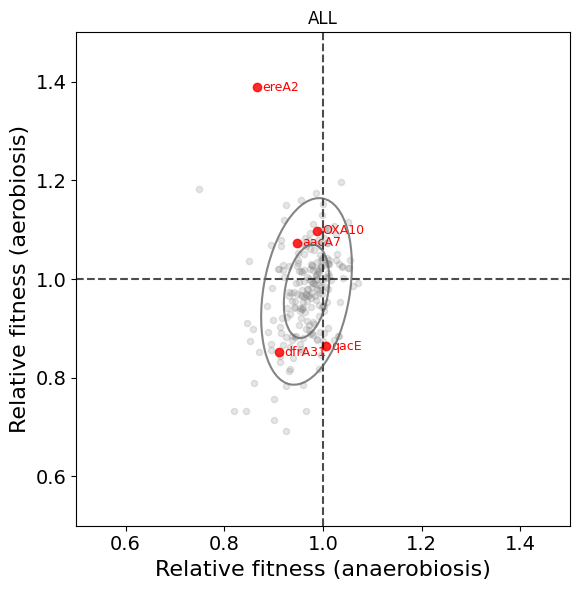

[dfr] df_env shape: (38, 13)
     label      Vmax        K             c  target_w  achieved_w   abs_err  \
0   dfrA31  0.919744  1.99647  1.128060e-09  0.851843    0.852990  0.001147   
1   dfrA31  0.929243  1.99647  1.260933e-09  0.912107    0.910893  0.001215   
2    dfrB4  0.922227  1.99647  1.094473e-09  0.868010    0.866782  0.001228   
3    dfrB4  0.926711  1.99647  1.146607e-09  0.895380    0.895671  0.000291   
4    dfrB2  0.925759  1.99647  1.246084e-09  0.888793    0.890175  0.001382   
5    dfrB2  0.942765  1.99647  1.145143e-09  0.999689    0.997937  0.001752   
6    dfrA7  0.927665  1.99647  1.014510e-09  0.900585    0.900094  0.000490   
7    dfrA7  0.920786  1.99647  1.035709e-09  0.858955    0.859129  0.000174   
8    dfrB8  0.935973  1.99647  1.120472e-09  0.954130    0.953539  0.000591   
9    dfrB8  0.936582  1.99647  1.151289e-09  0.958227    0.960762  0.002535   
10  dfrA12  0.936113  1.99647  1.103848e-09  0.954591    0.954227  0.000364   
11  dfrA12  0.933541  1

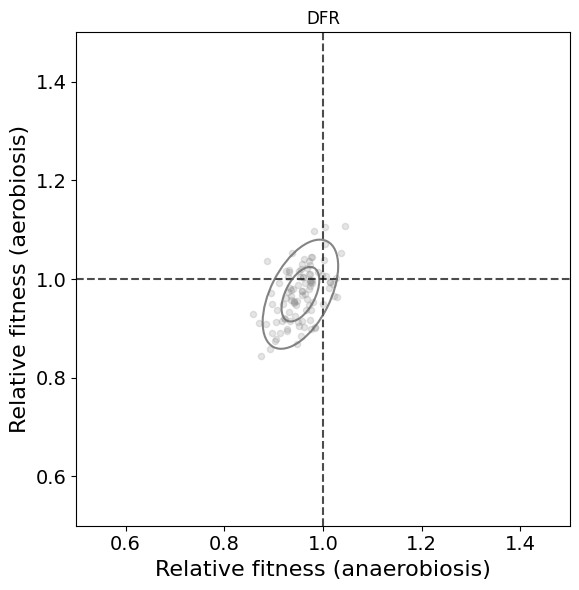

[bla] df_env shape: (20, 13)
     label      Vmax        K             c  target_w  achieved_w   abs_err  \
0     VIM2  0.894274  1.99647  1.240199e-09  0.713427    0.715043  0.001616   
1     VIM2  0.927673  1.99647  1.210263e-09  0.901215    0.899763  0.001452   
2     OXA2  0.897880  1.99647  1.011916e-09  0.731454    0.730575  0.000879   
3     OXA2  0.918347  1.99647  1.131799e-09  0.844851    0.844830  0.000021   
4   OXA118  0.898166  1.99647  1.136192e-09  0.733002    0.734513  0.001511   
5   OXA118  0.937859  1.99647  1.100512e-09  0.966668    0.965551  0.001116   
6    IMP31  0.898243  1.99647  1.157695e-09  0.733117    0.733859  0.000742   
7    IMP31  0.914025  1.99647  1.100842e-09  0.819042    0.819374  0.000332   
8   OXA129  0.908656  1.99647  1.100522e-09  0.789922    0.789732  0.000190   
9   OXA129  0.921158  1.99647  1.144715e-09  0.861404    0.861363  0.000040   
10    VIM7  0.929187  1.99647  1.037104e-09  0.910326    0.910328  0.000002   
11    VIM7  0.940043  1

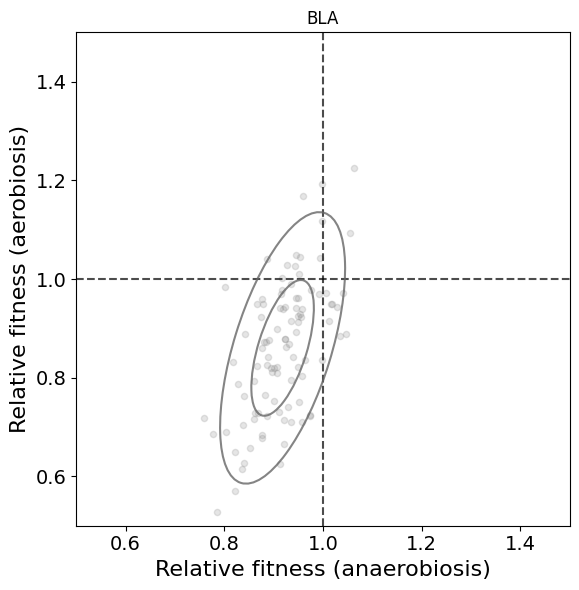

[aa] df_env shape: (98, 13)
     label      Vmax        K             c  target_w  achieved_w   abs_err  \
0     aadB  0.907864  1.99647  1.024166e-09  0.784562    0.783906  0.000656   
1     aadB  0.936731  1.99647  1.112867e-09  0.958875    0.959870  0.000995   
2   aacA30  0.917805  1.99647  1.123106e-09  0.842247    0.842169  0.000078   
3   aacA30  0.929419  1.99647  1.140957e-09  0.912063    0.911132  0.000931   
4    aacC4  0.920966  1.99647  1.085217e-09  0.859806    0.860379  0.000573   
..     ...       ...      ...           ...       ...         ...       ...   
93  aacA42  0.931350  1.99647  1.151716e-09  0.924070    0.924017  0.000053   
94  aadA11  0.964120  1.99647  1.279042e-09  1.153577    1.153011  0.000566   
95  aadA11  0.942474  1.99647  1.092424e-09  0.998581    0.998095  0.000486   
96  aphA16  0.967314  1.99647  1.008223e-09  1.182908    1.180237  0.002671   
97  aphA16  0.901027  1.99647  1.236462e-09  0.747095    0.749717  0.002621   

            loss    fA_

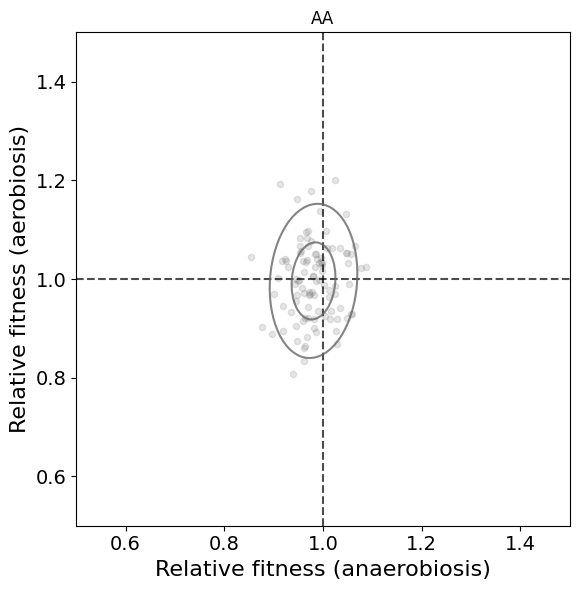

[mix] df_env shape: (44, 13)
        label      Vmax        K             c  target_w  achieved_w  \
0   qacEDsul1  0.920963  1.99647  1.238716e-09  0.860890    0.861980   
1   qacEDsul1  0.933047  1.99647  1.135193e-09  0.934488    0.934939   
2        qacE  0.921622  1.99647  1.121122e-09  0.865033    0.864402   
3        qacE  0.943892  1.99647  1.161715e-09  1.007082    1.006615   
4        qacM  0.924003  1.99647  1.175211e-09  0.878880    0.879912   
5        qacM  0.940972  1.99647  1.039866e-09  0.986801    0.988514   
6        fosK  0.924922  1.99647  1.132271e-09  0.884722    0.884185   
7        fosK  0.934859  1.99647  1.049912e-09  0.945572    0.946593   
8        qacG  0.925979  1.99647  1.100027e-09  0.890363    0.890470   
9        qacG  0.939470  1.99647  1.113630e-09  0.978039    0.977700   
10       fosN  0.928537  1.99647  1.095256e-09  0.906155    0.907265   
11       fosN  0.938571  1.99647  1.082835e-09  0.971015    0.971530   
12      catB2  0.929340  1.99647  1

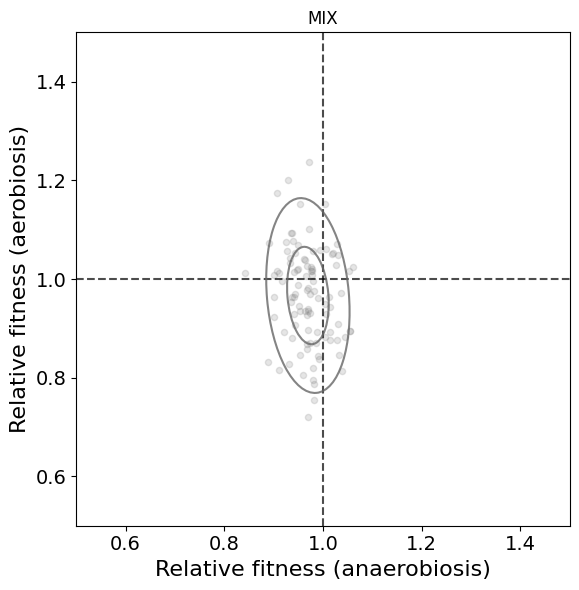

In [34]:
for family in families:
        
        p0_E = p0_from_df(p0_df, "E")
        p0_G = p0_from_df(p0_df, "G")
        csv_path = REPO_ROOT / "data" / f"fitness_{family}.csv"
        df_env = load_fitness_family_csv(csv_path, family)
        
        print(f"[{family}] df_env shape:", df_env.shape)
        print(df_env)
        syn_targets = build_synthetic_targets_for_family(
            family=family,
            fitness_E_csv=REPO_ROOT / "data" / "ARC_fitness_aerobiosis.csv",
            fitness_G_csv=REPO_ROOT / "data" / "ARC_fitness_anaerobiosis.csv",
            fits_csv=REPO_ROOT / "data" / "params_fits.csv",
            n=n_syn,
            min_r2=0.9,
            clip_range=(0.05, 3.0),
            seed=123,
        )
        
        
        if "pair_idx" in df_env.columns and df_env["pair_idx"].notna().any():
            start_idx = int(df_env["pair_idx"].max()) + 1
        else:
            start_idx = 0
        
       
        
        
        labels = df_env["label"].astype(str)
        has_synthetic = labels.apply(is_synthetic_label).any()
        
        n_syn_existing = int(labels.apply(is_synthetic_label).sum())
        n_syn_needed = max(int(n_syn) - n_syn_existing, 0)
        
        need_syn = (n_syn_needed > 0) and ("syn_targets" in locals()) and (syn_targets is not None) and (len(syn_targets) > 0)
        
        print(f"[{family}] synthetic existing={n_syn_existing}, missing={n_syn_needed}, need_syn={need_syn}")
        
        rows_syn = []
        if need_syn:
            syn_use = syn_targets.head(n_syn_needed).reset_index(drop=True)
        
            for k, row in syn_use.iterrows():
                wE = float(row["w_E_target"])
                wG = float(row["w_G_target"])
                pair_idx = int(start_idx) + int(k)
                label = f"x_{pair_idx:04d}"
        
                row_E, row_G = calibrate_arc_for_targets_Vrho(
                    label=label,
                    family=family,
                    w_E_target=wE,
                    w_G_target=wG,
                    p0_E=p0_E,
                    p0_G=p0_G,
                    sim_fn=gillespie_bacterial_growth_batch,
                    initial_resource=1.0,
                    simulation_time=24.0,
                    freqA0=0.5,
                    Ntot0=1e6,
                    verbose=True,
                )
        
                for r in (row_E, row_G):
                    r["label"] = label
                    r["family"] = family
                    r["pair_idx"] = pair_idx
                    r["method"] = row.get("method", np.nan)
                    r["rho_used"] = row.get("rho_used", np.nan)
        
                rows_syn.extend([row_E, row_G])
        else:
            print(f"[{family}] synthetic calibration skipped")
        
        df_syn = pd.DataFrame(rows_syn)
        
        
        df_env = pd.concat([df_emp_keep, df_emp_fitted, df_syn], ignore_index=True)
        print(f"[{family}] df_env shape: {df_env.shape}")
        
        
        
        did_calibrate = (
            (df_emp_fitted is not None and not df_emp_fitted.empty) or
            (df_syn is not None and not df_syn.empty)
        )
        
        if not did_calibrate:
            print(f"[{family}] No calibration performed. Skipping save.")
        else:
            df_env_updated = apply_empirical_fits_inplace(
                df_env, df_emp_fitted, cols_to_update=EXPORT_COLS
            )
        
            df_env_out = pd.concat([df_env_updated, df_syn], ignore_index=True)
            df_env_out = enforce_export_schema(df_env_out, EXPORT_COLS, keep_extra=False)
        
            out_path = REPO_ROOT / "data" / f"fitness_{family}.csv"
            out_path.parent.mkdir(parents=True, exist_ok=True)
        
            df_env_out.to_csv(out_path, index=False)
            print(f"[{family}] Wrote {len(df_env_out)} rows → {out_path}")
        
            df_env = df_env_out
        
        
        
        plot_w_scatter(
                df_env,
                family=family,
                highlight=[],                # or list of real strains to highlight
                annotate=labels_of_interest, # if defined
                ellipse_mode='rotated',
                pathFIGURES=''
        )